In [9]:
import pickle
import cv2
from pathlib import Path
from random import sample
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import display

In [2]:
img_dir = Path('r256/images/')
hm_dir = Path('kp_heatmaps/heatmaps/')
IDs = [p.stem for p in img_dir.glob('*.png')]
len(IDs)

27753

In [3]:
for ID in sample(IDs, 1):
    print(ID)
    img = Image.open(img_dir / f'{ID}.png')
    hm = pickle.load(open(hm_dir / f'{ID}.pkl', 'rb'))

id_00001507_02_2_side


In [4]:
hm.shape

(1, 17, 56, 56)

In [5]:
kp_dir = Path('kp_heatmaps/keypoints/')
kp = pickle.load(open(kp_dir / f'{ID}.pkl', 'rb'))

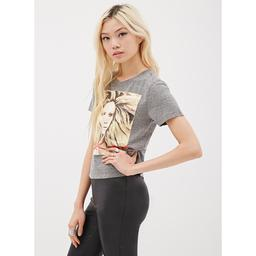

In [6]:
Image.open(img_dir / f'{ID}.png')

In [7]:
def cords_to_map(cords, img_size, old_size=None, affine_matrix=None, sigma=6):
    old_size = img_size if old_size is None else old_size
    cords = cords.astype(float)
    result = np.zeros(img_size + cords.shape[0:1], dtype='float32')
    for i, point in enumerate(cords):
        if point[0] == -1 or point[1] == -1:
            continue
        point[0] = point[0]/old_size[0] * img_size[0]
        point[1] = point[1]/old_size[1] * img_size[1]
        if affine_matrix is not None:
            point_ =np.dot(affine_matrix, np.matrix([point[1], point[0], 1]).reshape(3,1))
            point_0 = int(point_[1])
            point_1 = int(point_[0])
        else:
            point_0 = int(point[0])
            point_1 = int(point[1])
        xx, yy = np.meshgrid(np.arange(img_size[1]), np.arange(img_size[0]))
        result[..., i] = np.exp(-((yy - point_0) ** 2 + (xx - point_1) ** 2) / (2 * sigma ** 2))
    return result

(256, 256, 17)


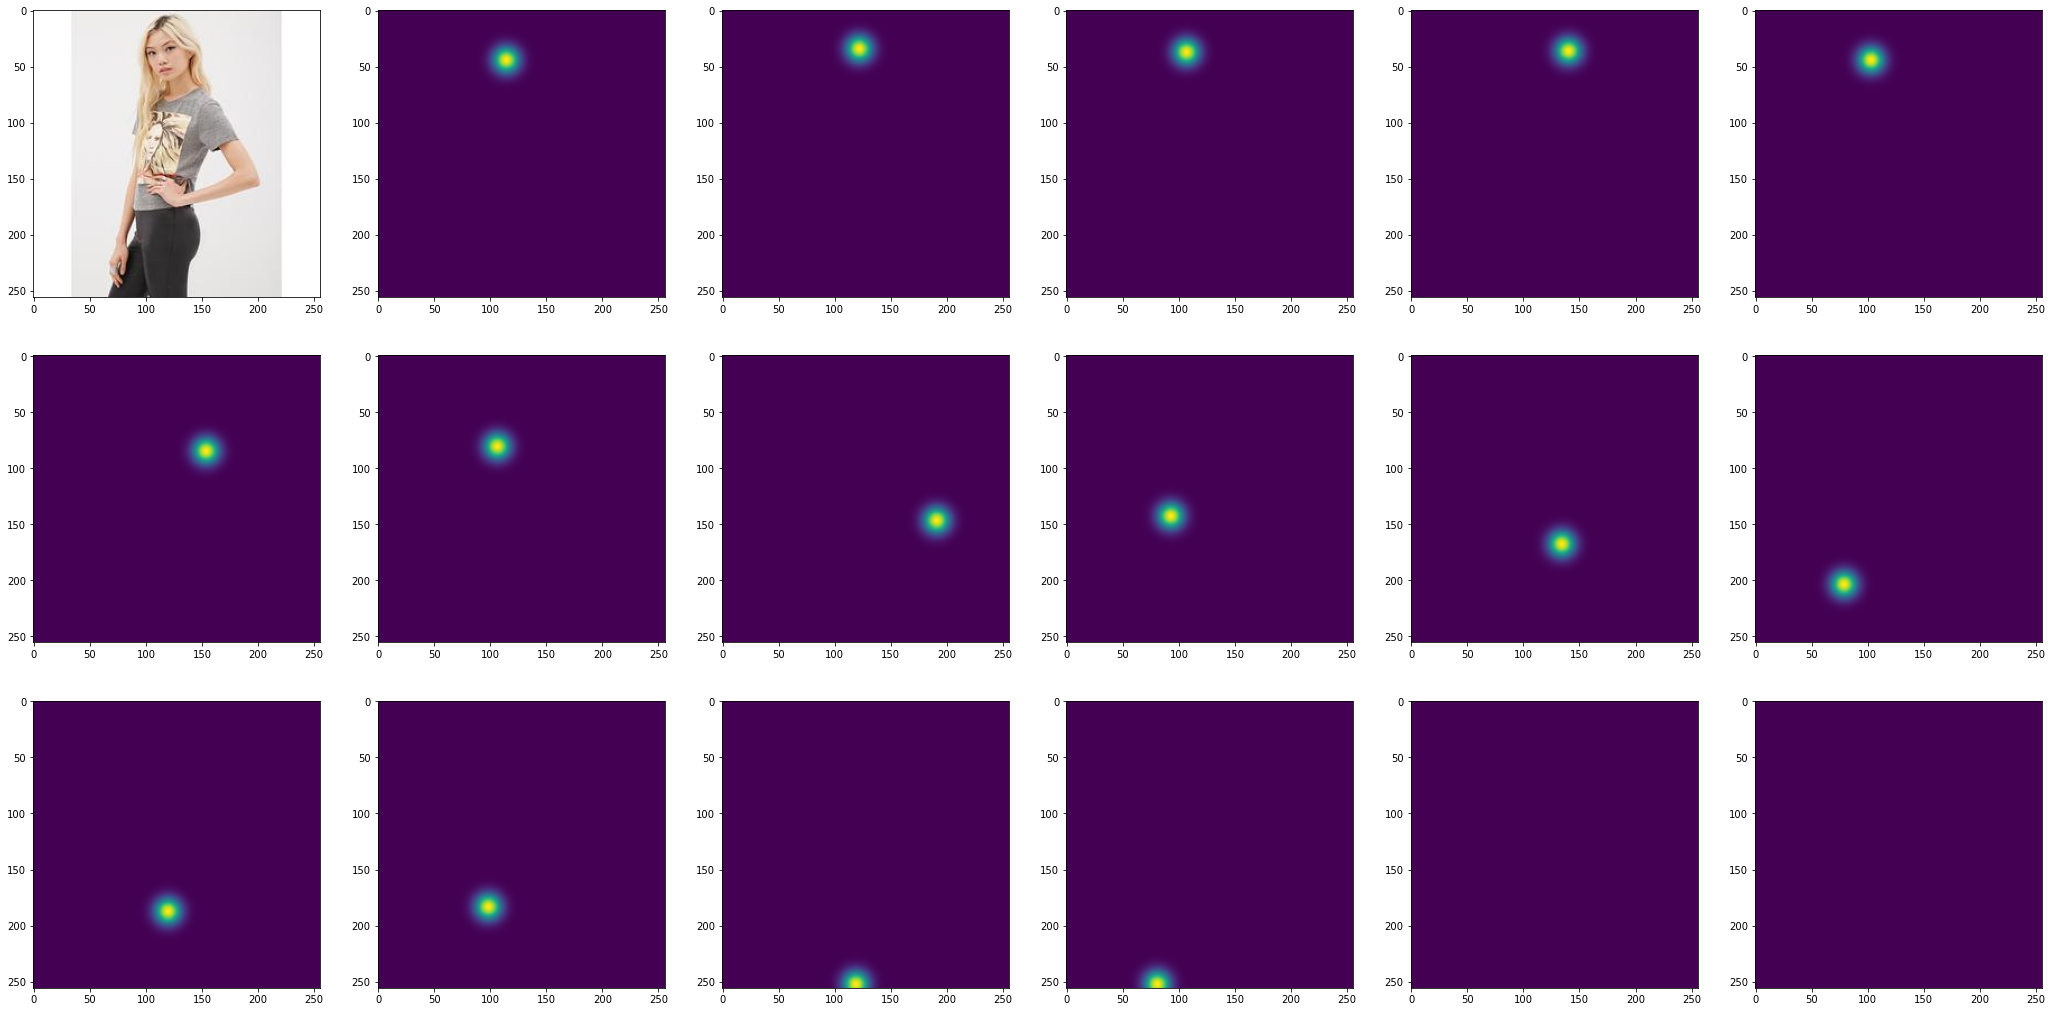

In [18]:
fig, ax = plt.subplots(3, 6, figsize=(36, 18))
ax[0,0].imshow(np.asarray(Image.open(img_dir / f'{ID}.png')))
kkp = kp[:, :, [1,0,2]]  # [B, K, (y, x, score)]
coords = np.where(np.expand_dims(kkp[0,:,2] > 0.1, axis=-1), kkp[0, :, :2], -np.ones_like(kkp[0, :, :2]))
maps = cords_to_map(coords, (256, 256), sigma=8)
print(maps.shape)
for i in range(1, maps.shape[-1]+1):
    ax[i//6, i%6].imshow(maps[..., i-1])

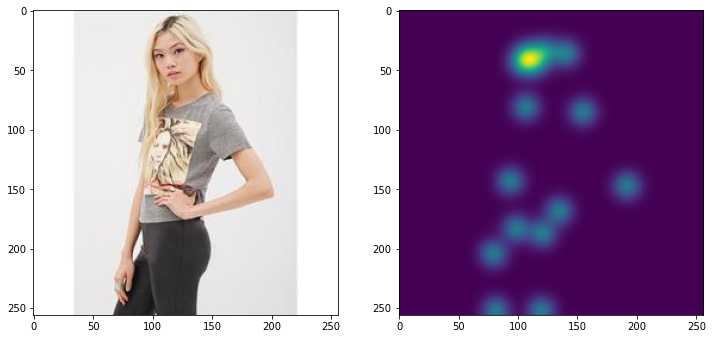

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(np.asarray(Image.open(img_dir / f'{ID}.png')))
kkp = kp[:, :, [1,0,2]]  # [B, K, (y, x, score)]
coords = np.where(np.expand_dims(kkp[0,:,2] > 0.1, axis=-1), kkp[0, :, :2], -np.ones_like(kkp[0, :, :2]))
maps = cords_to_map(coords, (256, 256), sigma=8)
ax[1].imshow(maps.sum(axis=-1))

In [21]:
plt.axis('off')
plt.imshow(maps.sum(axis=-1))
plt.savefig('heatmaps_example.png', bbox_inches='tight',pad_inches = 0)
Image.open(img_dir / f'{ID}.png').save('human_example.png')

In [60]:

from skimage.draw import circle, line_aa

LIMB_SEQ = [[0,1], [0,2], [1,3], [2,4], [5,6], [5,7], [6,8], [7,9], [8,10], [5,11],
            [6,12], [11,13], [12,14], [13,15], [14,16]]

COLORS = [[255, 0, 0], [255, 85, 0], [255, 170, 0], [255, 255, 0], [170, 255, 0], [85, 255, 0], [0, 255, 0],
          [0, 255, 85], [0, 255, 170], [0, 255, 255], [0, 170, 255], [0, 85, 255], [0, 0, 255], [85, 0, 255],
          [170, 0, 255], [255, 0, 255], [255, 0, 170], [255, 0, 85]]
MISSING_VALUE = -1

def draw_pose_from_cords(pose_joints, img_size, radius=2, draw_joints=True):
    colors = np.zeros(shape=img_size + (3, ), dtype=np.uint8)
    mask = np.zeros(shape=img_size, dtype=bool)

    if draw_joints:
        for f, t in LIMB_SEQ:
            from_missing = pose_joints[f][0] == MISSING_VALUE or pose_joints[f][1] == MISSING_VALUE
            to_missing = pose_joints[t][0] == MISSING_VALUE or pose_joints[t][1] == MISSING_VALUE
            if from_missing or to_missing:
                continue
            yy, xx, val = line_aa(pose_joints[f][0], pose_joints[f][1], pose_joints[t][0], pose_joints[t][1])
            colors[yy, xx] = np.expand_dims(val, 1) * 255
            mask[yy, xx] = True

    for i, joint in enumerate(pose_joints):
        if pose_joints[i][0] == MISSING_VALUE or pose_joints[i][1] == MISSING_VALUE:
            continue
        yy, xx = circle(joint[0], joint[1], radius=radius, shape=img_size)
        print(yy, xx, i)
        colors[yy, xx] = COLORS[i]
        mask[yy, xx] = True

    return colors, mask

colors, mask = draw_pose_from_cords(coords.astype(int), (256, 256))

[25 25 25 26 26 26 27 27 27] [128 129 130 128 129 130 128 129 130] 0
[21 21 21 22 22 22 23 23 23] [133 134 135 133 134 135 133 134 135] 1
[21 21 21 22 22 22 23 23 23] [124 125 126 124 125 126 124 125 126] 2
[24 24 24 25 25 25 26 26 26] [139 140 141 139 140 141 139 140 141] 3
[24 24 24 25 25 25 26 26 26] [118 119 120 118 119 120 118 119 120] 4
[53 53 53 54 54 54 55 55 55] [147 148 149 147 148 149 147 148 149] 5
[52 52 52 53 53 53 54 54 54] [108 109 110 108 109 110 108 109 110] 6
[86 86 86 87 87 87 88 88 88] [149 150 151 149 150 151 149 150 151] 7
[87 87 87 88 88 88 89 89 89] [103 104 105 103 104 105 103 104 105] 8
[122 122 122 123 123 123 124 124 124] [155 156 157 155 156 157 155 156 157] 9
[120 120 120 121 121 121 122 122 122] [103 104 105 103 104 105 103 104 105] 10
[109 109 109 110 110 110 111 111 111] [142 143 144 142 143 144 142 143 144] 11
[109 109 109 110 110 110 111 111 111] [118 119 120 118 119 120 118 119 120] 12
[170 170 170 171 171 171 172 172 172] [138 139 140 138 139 140 1

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: FutureWarning: circle is deprecated in favor of disk.circle will be removed in version 0.19


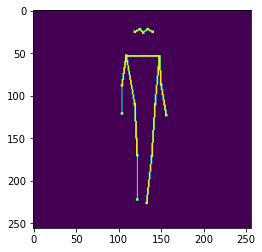

In [66]:
plt.imshow(mask)

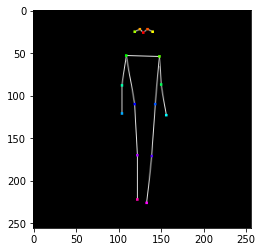

In [64]:
plt.imshow(colors)

In [58]:
coords.shape

(17, 2)

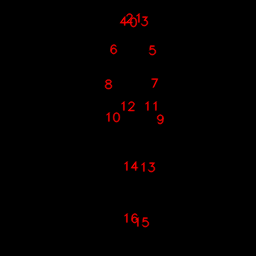

In [52]:
img = np.zeros((256,256, 3), dtype=np.uint8)
for i, k in enumerate(kp[0]):
    x, y, c = k
    #if c < 0.5:
    #    continue
    
    img = cv2.putText(img, str(i), (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 0, 0), 1, cv2.LINE_AA)
Image.fromarray(img)